In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os
import openpyxl
import seaborn as sns

pd.set_option("display.min_rows", 10)

In [2]:
class GetDataFrame:
    EQUIPMENT_LIST = ("CW500Viewer", "equip2")

    def __init__(self, equip_model: str, file_path: str):
        if equip_model not in self.EQUIPMENT_LIST:
            raise ValueError(f"equip_model must be one of {self.EQUIPMENT_LIST}. Got: {equip_model}")

        self.equip_model = equip_model
        self.file_path = file_path
        self.df = None  

    def load(self) -> pd.DataFrame:
        if self.equip_model == "CW500Viewer":
            self.df = self._get_and_clean_cw500_df()
            return self.df
            
        elif self.equip_model == "equip2":
            self.df = self._get_and_clean_equip2_df()
            return self.df
  
        raise ValueError(f"Unsupported equip_model: {self.equip_model}")

    def _get_and_clean_cw500_df(self) -> pd.DataFrame:
        df = pd.read_csv(self.file_path, sep=';', decimal=',', skiprows=37)

        rename_map = { 'AVG_P1[W][W]': 'Pa', 'AVG_P2[W][W]': 'Pb', 'AVG_P3[W][W]': 'Pc',
                       'AVG_Q1[var][var]': 'Qa', 'AVG_Q2[var][var]': 'Qb', 'AVG_Q3[var][var]': 'Qc'
                     }
        df = df.rename(columns=rename_map)

        cols = ['DateTime', 'Pa', 'Pb', 'Pc', 'Qa', 'Qb', 'Qc']
        df = df[cols]
        
        df["DateTime"] = pd.to_datetime(df["DateTime"], format="%Y/%m/%d %H:%M:%S")
        
        num_cols = cols[1:]
        df[num_cols] = df[num_cols].astype(float)

        return df

    def _get_and_clean_equip2_df(self) -> pd.DataFrame:
        df = pd.read_excel(path)
        if "Registro" in df.columns:
            df = df.rename(columns={'Registro': 'DateTime'})
        elif "time" in df.columns:
            df = df.rename(columns={'time': 'DateTime'})

        rename_map = { 'Pa [W]': 'Pa', 'Pb [W]': 'Pb', 'Pc [W]': 'Pc',
                       'Qa [VAr]': 'Qa', 'Qb [VAr]': 'Qb', 'Qc [VAr]': 'Qc'
                     }    
        df = df.rename(columns=rename_map)

        mask = df.map(lambda x: isinstance(x, str)).any(axis=1)
        df = df[~mask].reset_index(drop=True)

        cols = ['DateTime', 'Pa', 'Pb', 'Pc', 'Qa', 'Qb', 'Qc']
        df = df[cols]

        df["DateTime"] = pd.to_datetime(df["DateTime"], format="%Y/%m/%d %H:%M:%S")
        
        num_cols = cols[1:]
        df[num_cols] = df[num_cols].astype(float)
        
        return df

In [3]:
equip_model = 'CW500Viewer'

In [4]:
if equip_model == 'CW500Viewer':
    _dir = r"..\00_data\CW500Viewer\0_data_TR_DT_DC_PST_FP"
    files = [file for file in os.listdir(_dir) if file.endswith(".csv")]
elif equip_model == "equip2":
    _dir = r"..\00_data\Arquivos_CD_Rennner\CD_Rennner_files"
    files = [file for file in os.listdir(_dir) if file.endswith(".xlsx")]

list(zip(list(range(len(files))),files))

[(0, 'dados_qgbt2_INPS0014.csv'),
 (1, 'dados_qgbt3_INPS0013.csv'),
 (2, 'dados_qgbt4_INPS0011.csv')]

In [5]:
path = os.path.join(_dir, files[0])
path

'..\\00_data\\CW500Viewer\\0_data_TR_DT_DC_PST_FP\\dados_qgbt2_INPS0014.csv'

In [6]:
df = GetDataFrame(equip_model, path).load()
df

,DateTime,Pa,Pb,Pc,Qa,Qb,Qc
0,2023-03-03 14:38:43,56190.0,60820.0,66500.0,17700.0,16680.0,24730.0
1,2023-03-03 14:48:43,54640.0,56990.0,65880.0,17420.0,15020.0,24020.0
2,2023-03-03 14:58:43,51420.0,56120.0,62270.0,15450.0,14620.0,21170.0
3,2023-03-03 15:08:43,50860.0,52970.0,60850.0,15020.0,14070.0,21120.0
4,2023-03-03 15:18:43,48950.0,47240.0,57730.0,13560.0,11910.0,19640.0
...,...,...,...,...,...,...,...
1454,2023-03-13 16:58:43,48260.0,46020.0,48330.0,12720.0,10250.0,15950.0
1455,2023-03-13 17:08:43,47490.0,47170.0,46120.0,12760.0,11080.0,15620.0
1456,2023-03-13 17:18:43,44030.0,42220.0,41560.0,11970.0,9106.0,13980.0
1457,2023-03-13 17:28:43,40320.0,38030.0,36900.0,9695.0,7485.0,11220.0


# Define Parameters

In [7]:
Workday = {
    "H_DAY": dt.time(7, 0, 0),
    "H_PEAK": dt.time(18, 0, 0),
    "H_EVENING": dt.time(21, 0, 0),
    "H_NIGHT": dt.time(23, 59, 59),
}

weekdays = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}

# Create DF with just 1008 measurement points

In [8]:
data_PF = df.iloc[0:1008].copy()
data_PF["Weekday"] = data_PF["DateTime"].dt.weekday
data_PF["Weekday_EN"] = data_PF["Weekday"].map(weekdays)

# --------- Determine time period (using dict)
data_PF["Time_Type"] = [
    "Day: 07h-18h" if (t >= Workday["H_DAY"]) and (t < Workday["H_PEAK"]) else
    "Peak: 18h-21h" if (t >= Workday["H_PEAK"]) and (t < Workday["H_EVENING"]) else
    "Night: 21h-00h" if (t >= Workday["H_EVENING"]) and (t < Workday["H_NIGHT"]) else
    "Early_Morning: 00h-07h"
    for t in data_PF["DateTime"].dt.time
]

data_PF

,DateTime,Pa,Pb,Pc,Qa,Qb,Qc,Weekday,Weekday_EN,Time_Type
0,2023-03-03 14:38:43,56190.0,60820.0,66500.0,17700.0,16680.0,24730.0,4,Friday,Day: 07h-18h
1,2023-03-03 14:48:43,54640.0,56990.0,65880.0,17420.0,15020.0,24020.0,4,Friday,Day: 07h-18h
2,2023-03-03 14:58:43,51420.0,56120.0,62270.0,15450.0,14620.0,21170.0,4,Friday,Day: 07h-18h
3,2023-03-03 15:08:43,50860.0,52970.0,60850.0,15020.0,14070.0,21120.0,4,Friday,Day: 07h-18h
4,2023-03-03 15:18:43,48950.0,47240.0,57730.0,13560.0,11910.0,19640.0,4,Friday,Day: 07h-18h
...,...,...,...,...,...,...,...,...,...,...
1003,2023-03-10 13:48:43,52050.0,49020.0,52280.0,14710.0,12250.0,18590.0,4,Friday,Day: 07h-18h
1004,2023-03-10 13:58:43,52120.0,47630.0,52310.0,14220.0,11740.0,18010.0,4,Friday,Day: 07h-18h
1005,2023-03-10 14:08:43,50930.0,47700.0,51310.0,13760.0,11390.0,17600.0,4,Friday,Day: 07h-18h
1006,2023-03-10 14:18:43,53730.0,51400.0,56080.0,16110.0,12930.0,20440.0,4,Friday,Day: 07h-18h


# P and Q Charts

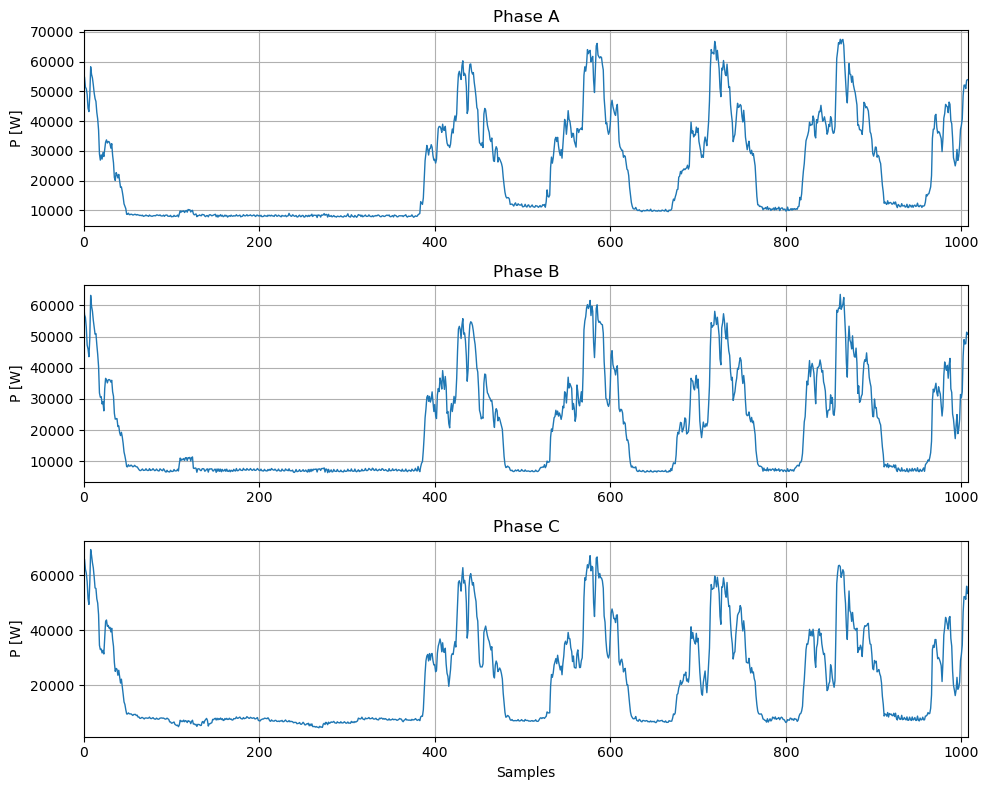

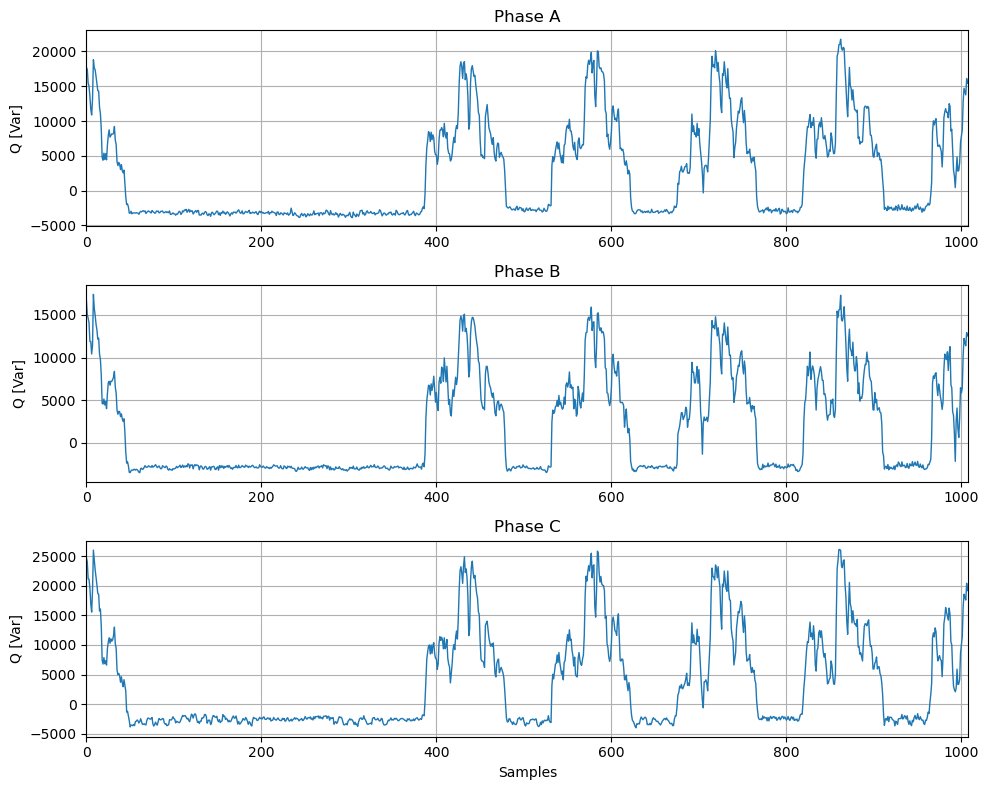

In [9]:
# Number of samples
Nsteps = 1008
t = np.arange(Nsteps)

# Function to plot P or Q graphs per phase
def edit_pq_plot(ax, values, phase, power_type="P"):
    ax.grid(True)
    ax.plot(t, values.iloc[:Nsteps], linewidth=1)
    ax.set_xlim([0, Nsteps])
    ax.set_ylabel(f"{power_type} [W]" if power_type == "P" else f"{power_type} [Var]")
    ax.set_title(f"Phase {phase}")

# --- Active Power (P) Plots ---
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3, ncols=1, sharex=False, figsize=(10, 8)
)
edit_pq_plot(ax1, data_PF["Pa"], "A", power_type="P")
edit_pq_plot(ax2, data_PF["Pb"], "B", power_type="P")
edit_pq_plot(ax3, data_PF["Pc"], "C", power_type="P")
ax3.set_xlabel("Samples")
plt.tight_layout()
plt.show()

# --- Reactive Power (Q) Plots ---
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3, ncols=1, sharex=False, figsize=(10, 8)
)
edit_pq_plot(ax1, data_PF["Qa"], "A", power_type="Q")
edit_pq_plot(ax2, data_PF["Qb"], "B", power_type="Q")
edit_pq_plot(ax3, data_PF["Qc"], "C", power_type="Q")
ax3.set_xlabel("Samples")
plt.tight_layout()
plt.show()


# Calculate PF

<div style="font-size: 150%;">
$$
PF = \frac{P}{\sqrt{P^{2} + Q^{2}}}
$$
</div>


In [10]:
# Function in the same style as add_beta_np
def add_pf_np(df, P_col, Q_col, out):
    P = df[P_col].to_numpy(dtype=float)
    Q = df[Q_col].to_numpy(dtype=float)
    denom = np.sqrt(P**2 + Q**2)
    df[out] = np.divide(P, denom, out=np.full_like(denom, np.nan, dtype=float), where=denom != 0,)
    return df



In [11]:
# Apply the function to each phase
data_PF = add_pf_np(data_PF, "Pa", "Qa", "PF_a")
data_PF = add_pf_np(data_PF, "Pb", "Qb", "PF_b")
data_PF = add_pf_np(data_PF, "Pc", "Qc", "PF_c")

data_PF.head(2)

,DateTime,Pa,Pb,Pc,Qa,Qb,Qc,Weekday,Weekday_EN,Time_Type,PF_a,PF_b,PF_c
0,2023-03-03 14:38:43,56190.0,60820.0,66500.0,17700.0,16680.0,24730.0,4,Friday,Day: 07h-18h,0.953798,0.96439,0.937287
1,2023-03-03 14:48:43,54640.0,56990.0,65880.0,17420.0,15020.0,24020.0,4,Friday,Day: 07h-18h,0.952752,0.96698,0.939502


# PF Limit

<div style="font-size: 150%;">
$$
\mathrm{FP} \ge 0.92
$$

In [12]:
def add_pf_status(df, pf_col, limit):
    """
    Adds OK flag and status columns for a given power factor column.
    """
    phase = pf_col.split("_")[-1]

    ok_col = f"PF_{phase}_ok"
    status_col = f"PF_{phase}_status"

    df[ok_col] = df[pf_col] >= limit
    df[status_col] = np.where(df[ok_col], "OK", "Below limit")

    return df

In [13]:
pf_limit = 0.92

for phase in ["a", "b", "c"]:
    data_FP = add_pf_status(data_PF, f"PF_{phase}", pf_limit)
data_PF.head(2)

,DateTime,Pa,Pb,Pc,Qa,Qb,Qc,Weekday,Weekday_EN,Time_Type,PF_a,PF_b,PF_c,PF_a_ok,PF_a_status,PF_b_ok,PF_b_status,PF_c_ok,PF_c_status
0,2023-03-03 14:38:43,56190.0,60820.0,66500.0,17700.0,16680.0,24730.0,4,Friday,Day: 07h-18h,0.953798,0.96439,0.937287,True,OK,True,OK,True,OK
1,2023-03-03 14:48:43,54640.0,56990.0,65880.0,17420.0,15020.0,24020.0,4,Friday,Day: 07h-18h,0.952752,0.96698,0.939502,True,OK,True,OK,True,OK


In [14]:
below_limit_count = {
    "Fase A": (data_PF["PF_a"] < pf_limit).sum(),
    "Fase B": (data_PF["PF_b"] < pf_limit).sum(),
    "Fase C": (data_PF["PF_c"] < pf_limit).sum(),
    "Total": ((data_PF["PF_a"] < pf_limit) | (data_PF["PF_b"] < pf_limit) | (data_PF["PF_c"] < pf_limit)).sum()
}
below_limit_count

{'Fase A': np.int64(75),
 'Fase B': np.int64(136),
 'Fase C': np.int64(127),
 'Total': np.int64(230)}

# Calculate Percentiles

$$
{\Large
L_k=\left[\,(n-1)\cdot\frac{k}{100}\,\right]+1
}
$$


In [15]:
# Percentil 95% para cada fase do FP
p95_pf_a = np.percentile(data_PF['PF_a'], 95)
p95_pf_b = np.percentile(data_PF['PF_b'], 95)
p95_pf_c = np.percentile(data_PF['PF_c'], 95)

# Mostra os resultados
[p95_pf_a, p95_pf_b, p95_pf_c]

[np.float64(0.9910766722442121),
 np.float64(0.990102255927839),
 np.float64(0.9867052405067455)]

# Charts

In [16]:
def plot_lollipop(
    df: pd.DataFrame,
    y_col: str,
    weekday_col: str,
    figsize=(16, 4),
    dpi: int = 300,
    y_lim=(0, 1.6),
    draw_boundaries: bool = True,
    shade_alternating: bool = True,
    constant_line_value: float = None,
    constant_line_label: str = "p95_fd_min",
):
    """
    Plots a lollipop chart and adds a secondary top X-axis
    with weekday intervals defined by another DataFrame column.

    Parameters
    ----------
    constant_line_value : float or None
        If provided, draws a horizontal red line at this value.
    constant_line_label : str or None
        Label shown in the legend for the horizontal line.
    """

    n = len(df)
    if n == 0:
        raise ValueError("Empty DataFrame.")

    # X-axis = sequential sample index
    x = np.arange(n)

    # Y series
    y = pd.to_numeric(df[y_col], errors="coerce").to_numpy()

    # Weekday column (as string)
    wd = df[weekday_col].astype(str).to_numpy()

    # --- Base plot (lollipop) ---
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.vlines(x, 0, y, linewidth=0.3)  # thin stems
    ax.scatter(x, y, s=5)              # top points

    ax.set_xlabel("Sample Number", fontsize=16)
    ax.set_ylabel(str(y_col), fontsize=16)

    if y_lim is not None:
        ax.set_ylim(*y_lim)

    ax.grid(True, axis="y", linewidth=0.3, alpha=0.5)

    # --- Constant horizontal line (optional) ---
    if constant_line_value is not None:
        ax.axhline(
            y=constant_line_value,
            color="red",
            linewidth=1,
            label=str(constant_line_label) if constant_line_label else None,
        )
        if constant_line_label:
            ax.legend(loc="upper right", fontsize=9, frameon=False)

    # --- Interval calculation (when weekday changes) ---
    if n > 1:
        change_idx = np.where(wd[1:] != wd[:-1])[0] + 1
    else:
        change_idx = np.array([], dtype=int)

    starts = np.r_[0, change_idx]
    ends = np.r_[change_idx, n]
    mids = (starts + ends - 1) / 2.0
    labels = [wd[s] for s in starts]

    # --- Top axis with weekday labels ---
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    ax_top.set_xticks(mids)
    ax_top.set_xticklabels(labels, fontsize=12)
    ax_top.xaxis.set_ticks_position("top")
    ax_top.tick_params(axis="x", which="both", length=0, pad=6)
    ax_top.set_xlabel("Weekdays", fontsize=16, labelpad=8)

    # Boundary lines between weekdays (optional)
    if draw_boundaries and len(change_idx) > 0:
        for idx in change_idx:
            ax.axvline(idx, linestyle="--", linewidth=0.5, alpha=0.5)

    # Alternating block shading (optional)
    if shade_alternating:
        for i, (s, e) in enumerate(zip(starts, ends)):
            if i % 2 == 0:
                ax.axvspan(s - 0.5, e - 0.5, alpha=0.06)

    plt.tight_layout()
    return fig, ax, ax_top


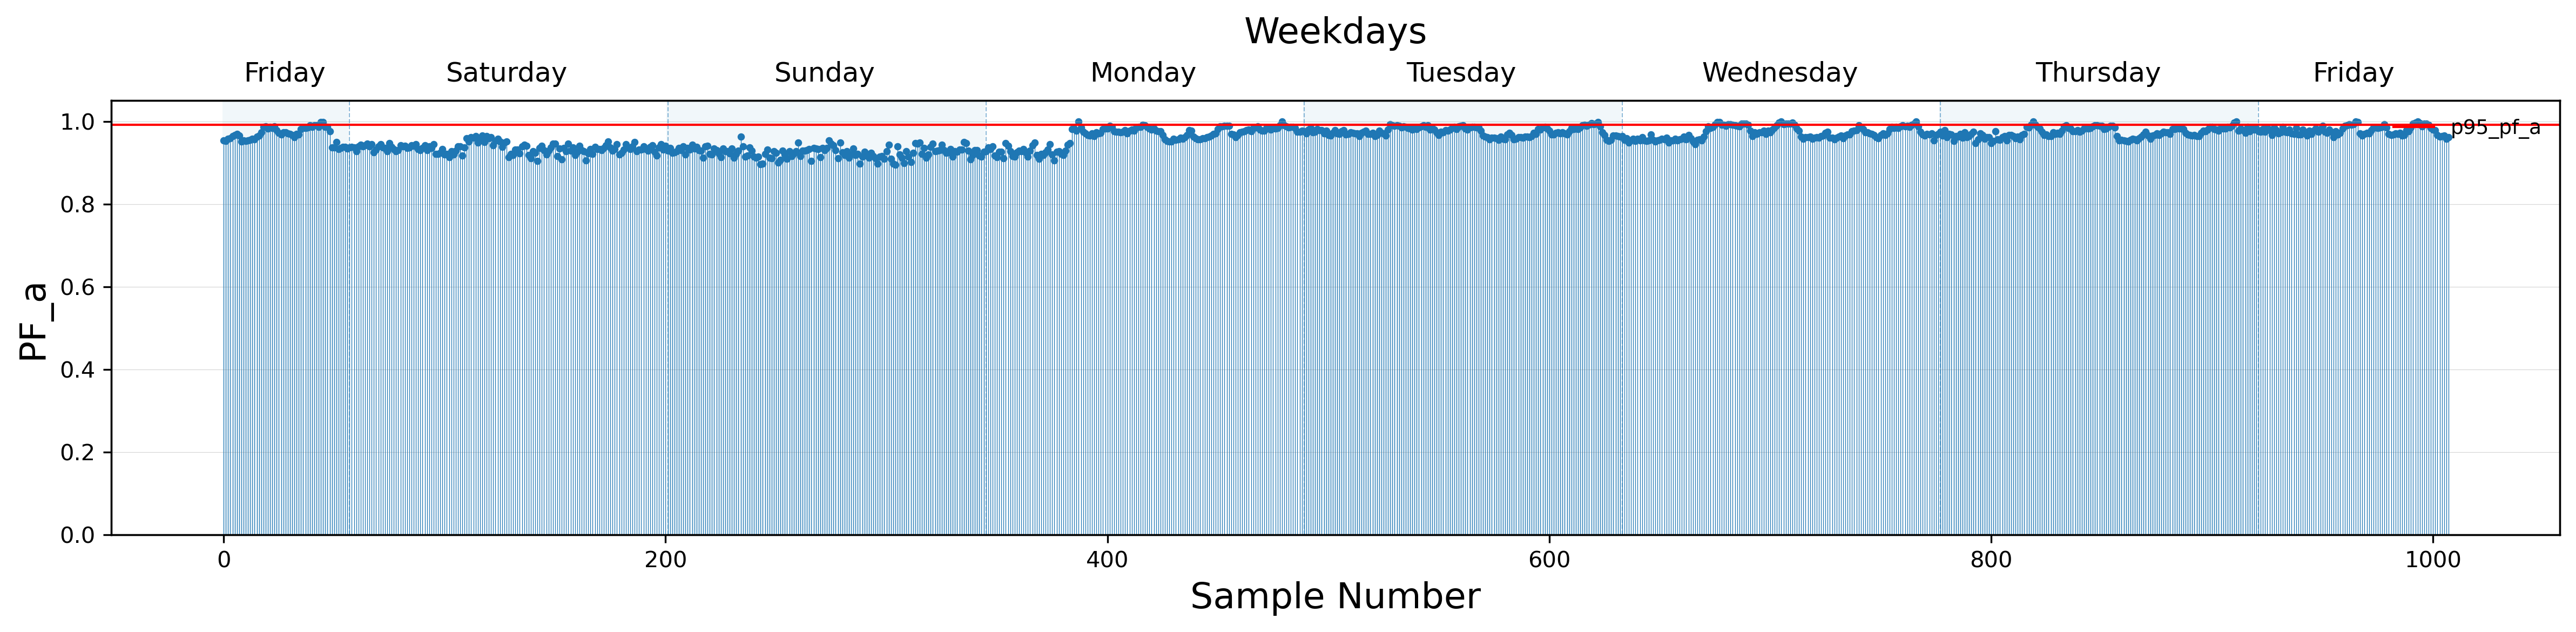

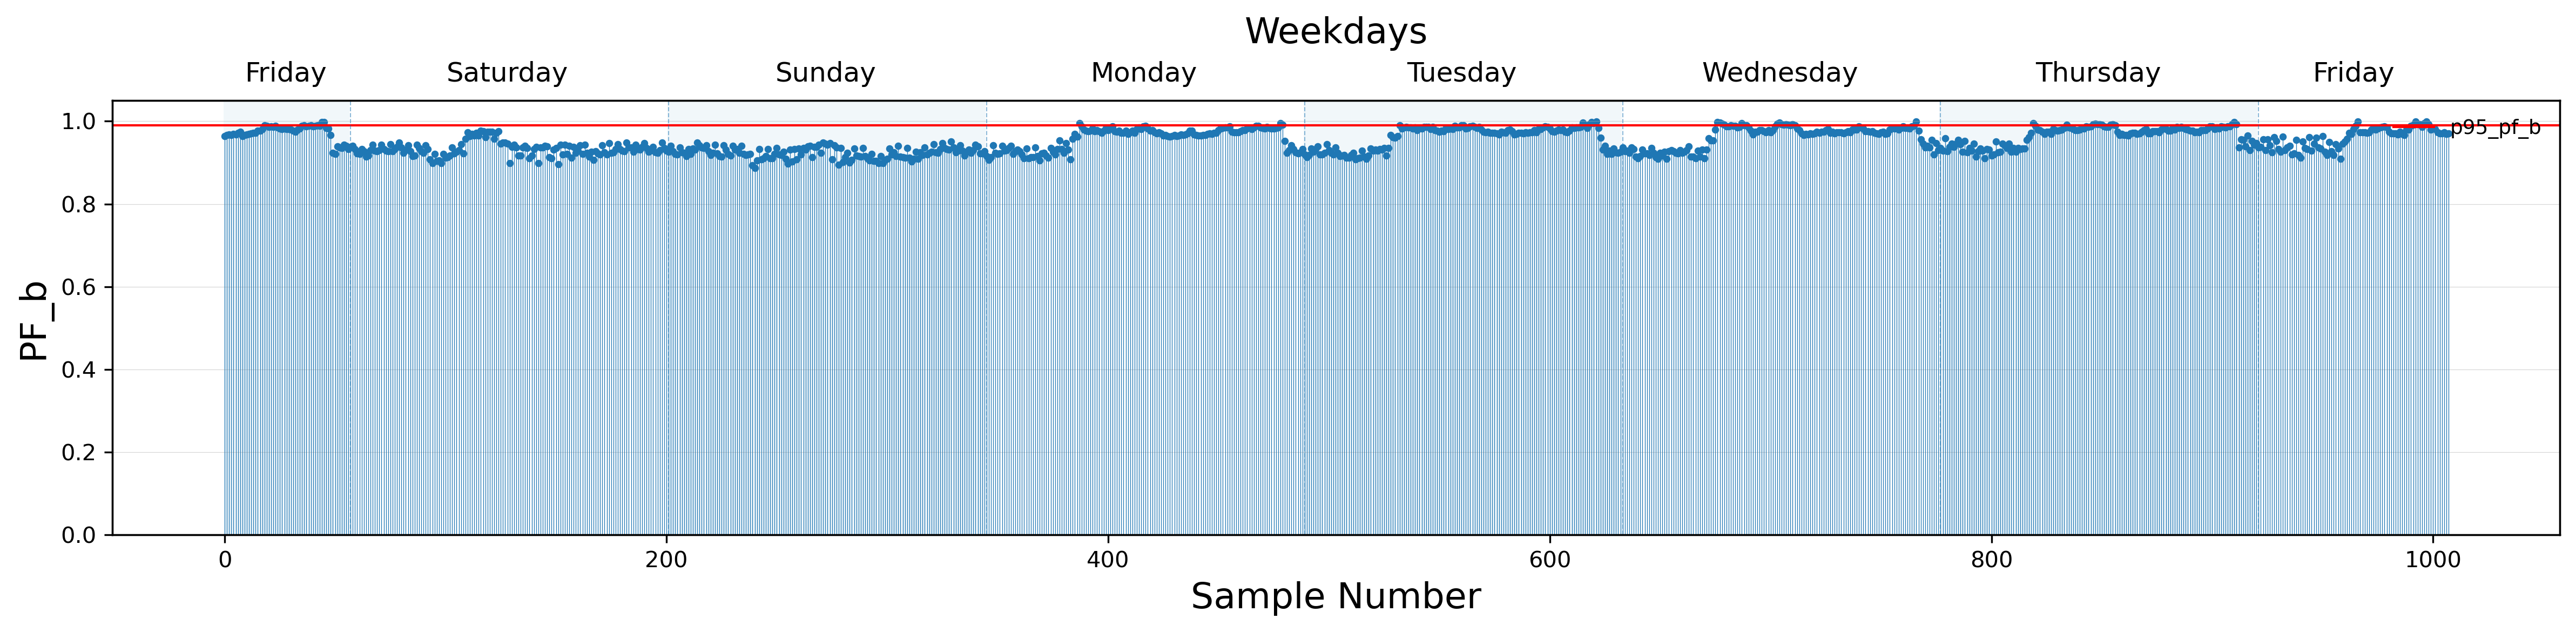

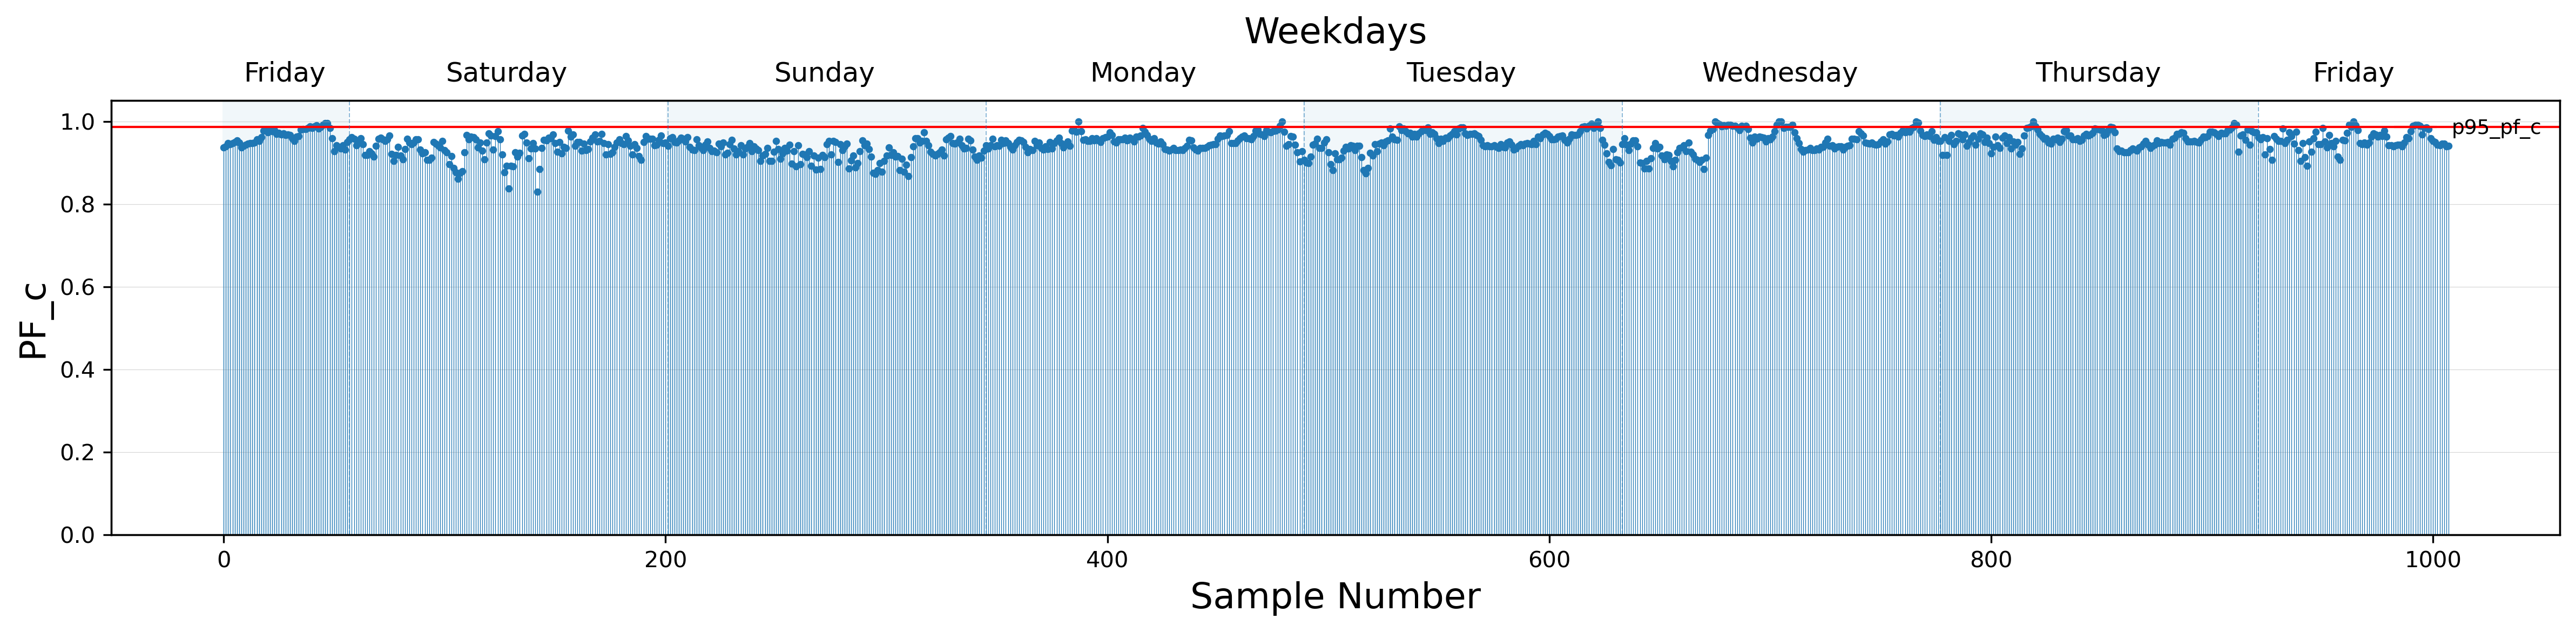

In [17]:
fig = plot_lollipop(data_PF, 'PF_a', 'Weekday_EN', constant_line_value=p95_pf_a, constant_line_label="p95_pf_a", y_lim = (0, data_PF['PF_a'].max()+ data_PF['PF_a'].max()*0.05))
fig = plot_lollipop(data_PF, 'PF_b', 'Weekday_EN', constant_line_value=p95_pf_b, constant_line_label="p95_pf_b", y_lim = (0, data_PF['PF_b'].max()+ data_PF['PF_b'].max()*0.05))
fig = plot_lollipop(data_PF, 'PF_c', 'Weekday_EN', constant_line_value=p95_pf_c, constant_line_label="p95_pf_c", y_lim = (0, data_PF['PF_c'].max()+ data_PF['PF_c'].max()*0.05))
plt.show()

# Pie Charts

In [18]:
def plot_pf_pie_chart(
    df,
    pf_column,
    phase,
    pf_limit=pf_limit,
    ax=None,
    startangle=90,
    figsize=(5, 5),
    legend_title="Power Factor",
    title_fontsize=16,
    title_pad=10,
):
    """
    Plot a pie chart showing Power Factor compliance for a given phase,
    using the same visual style as create_pie_chart_by_weekday_sns.
    """

    sns.set_theme(style="white")

    # Count samples
    counts = pd.Series(
        {
            "OK": (df[pf_column] >= pf_limit).sum(),
            "Below limit": (df[pf_column] < pf_limit).sum(),
        }
    )

    # Remove zero values
    counts = counts[counts > 0]

    if counts.sum() == 0:
        if ax is None:
            _, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
        ax.set_title(
            f"Phase {phase} | Power Factor (limit = {pf_limit})",
            fontsize=title_fontsize,
            pad=title_pad,
        )
        ax.axis("off")
        return ax

    # Order descending (not strictly needed here, but keeps consistency)
    counts = counts.sort_values(ascending=False)

    values = counts.values
    labels = counts.index.tolist()
    total = values.sum()
    percentages = values / total * 100

    legend_labels = [
        f"{label} ({pct:.1f}%)"
        for label, pct in zip(labels, percentages)
    ]

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    colors = sns.color_palette("tab10", len(values))

    wedges = ax.pie(
        values,
        labels=None,  # no labels inside the pie
        startangle=startangle,
        counterclock=False,
        colors=colors,
        wedgeprops={"linewidth": 1, "edgecolor": "white"},
    )[0]

    ax.axis("equal")
    ax.set_title(
        f"Phase {phase} | Power Factor (limit = {pf_limit})",
        fontsize=title_fontsize,
        pad=title_pad,
    )

    ax.legend(
        wedges,
        legend_labels,
        title=legend_title,
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
    )

    plt.tight_layout()
    return ax


<Axes: title={'center': 'Phase C | Power Factor (limit = 0.92)'}>

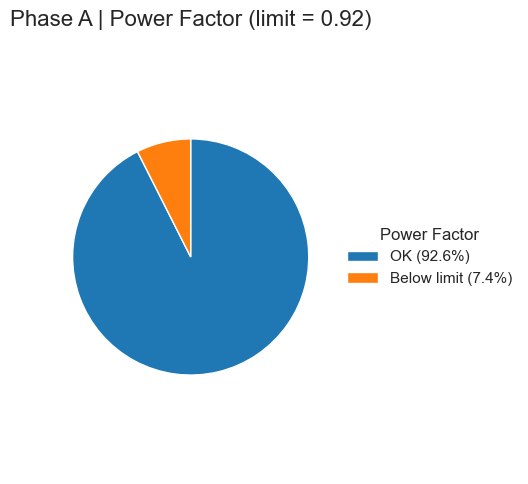

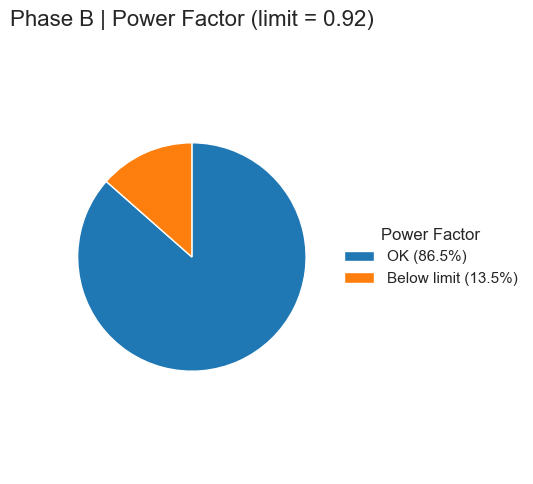

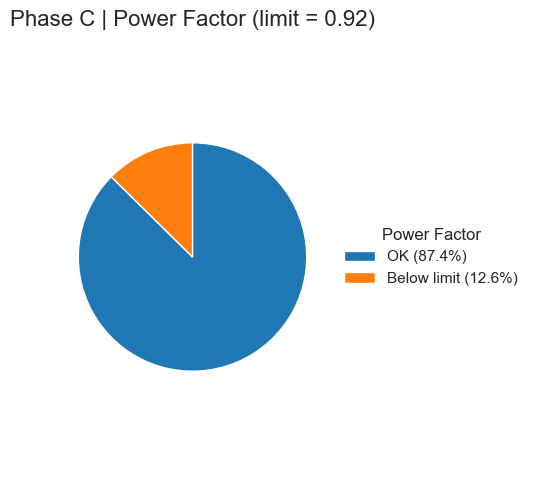

In [19]:
plot_pf_pie_chart(data_PF, 'PF_a', 'A', pf_limit)
plot_pf_pie_chart(data_PF, 'PF_b', 'B', pf_limit)
plot_pf_pie_chart(data_PF, 'PF_c', 'C', pf_limit)

In [20]:
def create_pie_chart_by_time_type_sns(
    df,
    column,
    flag_column,
    threshold_value,
    phase="",
    ax=None,
    startangle=90,
    figsize=(5, 5),
    legend_title="Category",
    title_fontsize=16,
    title_pad=10
):
    sns.set_theme(style="white")

    df = df.copy()
    df[flag_column] = np.where(df[column] > threshold_value, 1, 0)
    mask = df[flag_column] == 1

    counts = df.loc[mask, "Time_Type"].value_counts(dropna=False)
    counts = counts[counts > 0]

    if counts.sum() == 0:
        if ax is None:
            _, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
        ax.set_title(f"{phase} | {column} > {threshold_value}", fontsize=title_fontsize, pad=title_pad)
        ax.axis("off")
        return ax

    # Ordenar em ordem decrescente
    counts = counts.sort_values(ascending=False)
    values = counts.values
    labels = counts.index.tolist()
    total = values.sum()
    percentages = values / total * 100

    legend_labels = [f"{label} ({pct:.1f}%)" for label, pct in zip(labels, percentages)]

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    colors = sns.color_palette("tab10", len(values))

    wedges = ax.pie(
        values,
        labels=None,  # nada dentro da pizza
        startangle=startangle,
        counterclock=False,
        colors=colors,
        wedgeprops={"linewidth": 1, "edgecolor": "white"},
    )[0]

    ax.axis("equal")
    ax.set_title(f"{phase} | {column} > {threshold_value:.4f} by time of day",
                 fontsize=title_fontsize,
                 pad=title_pad)

    ax.legend(
        wedges,
        legend_labels,
        title=legend_title,
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
    )

    plt.tight_layout()
    return ax


<Axes: title={'center': ' | PF_c > 0.9200 by time of day'}>

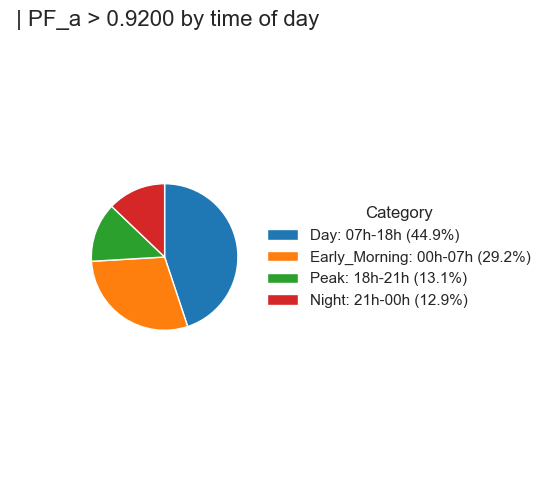

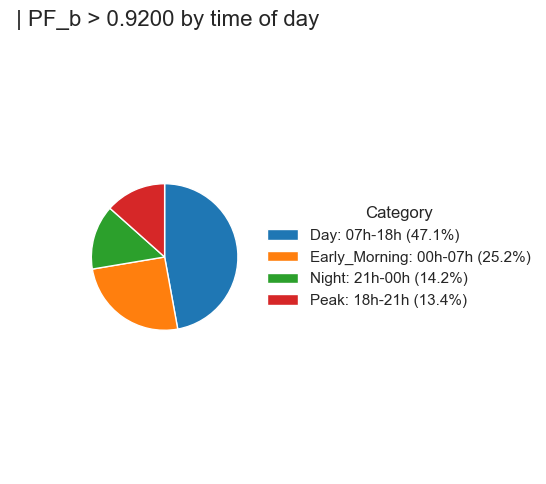

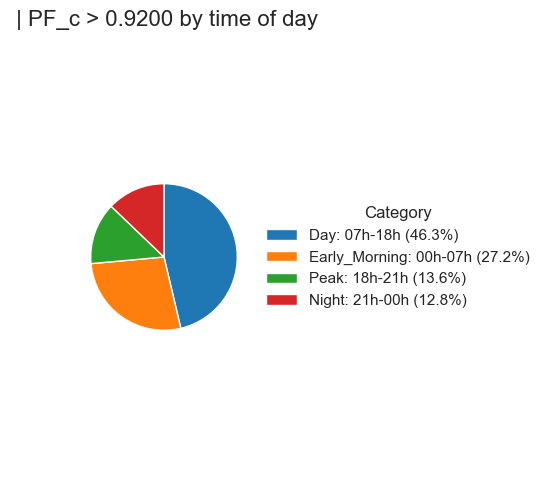

In [21]:
create_pie_chart_by_time_type_sns(data_PF, "PF_a", "flag_FP_a", pf_limit)
create_pie_chart_by_time_type_sns(data_PF, "PF_b", "flag_FP_b", pf_limit)
create_pie_chart_by_time_type_sns(data_PF, "PF_c", "flag_FP_c", pf_limit)

In [22]:
def create_pie_chart_by_weekday_sns(
    df,
    column,
    flag_column,
    threshold_value,
    phase="",
    ax=None,
    startangle=90,
    figsize=(5, 5),
    legend_title="Weekday",
    title_fontsize=16,
    title_pad=10
):

    sns.set_theme(style="white")

    order = [
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"
    ]

    df = df.copy()
    df[flag_column] = np.where(df[column] > threshold_value, 1, 0)
    mask = df[flag_column] == 1

    s = df.loc[mask, "Weekday_EN"].astype(
        pd.CategoricalDtype(categories=order, ordered=True)
    )
    counts = s.value_counts(sort=False)
    counts = counts[counts > 0]

    if counts.sum() == 0:
        if ax is None:
            _, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
        ax.set_title(f"{phase} | {column} > {threshold_value}", fontsize=title_fontsize, pad=title_pad)
        ax.axis("off")
        return ax

    # Ordenar em ordem decrescente
    counts = counts.sort_values(ascending=False)
    values = counts.values
    labels = counts.index.tolist()
    total = values.sum()
    percentages = values / total * 100

    legend_labels = [
        f"{label} ({pct:.1f}%)"
        for label, pct in zip(labels, percentages)
    ]

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    colors = sns.color_palette("tab10", len(values))

    wedges = ax.pie(
        values,
        labels=None,
        startangle=startangle,
        counterclock=False,
        colors=colors,
        wedgeprops={"linewidth": 1, "edgecolor": "white"},
    )[0]

    ax.axis("equal")
    ax.set_title(f"{phase} | {column} > {threshold_value:.4f} by weekday",
                 fontsize=title_fontsize,
                 pad=title_pad)

    ax.legend(
        wedges,
        legend_labels,
        title=legend_title,
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
    )

    plt.tight_layout()
    return ax


<Axes: title={'center': ' | PF_c > 0.9200 by weekday'}>

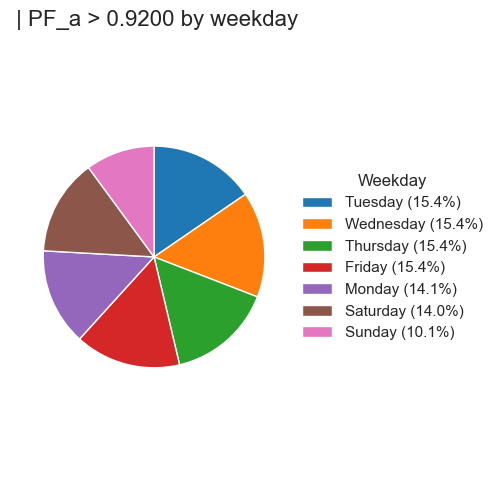

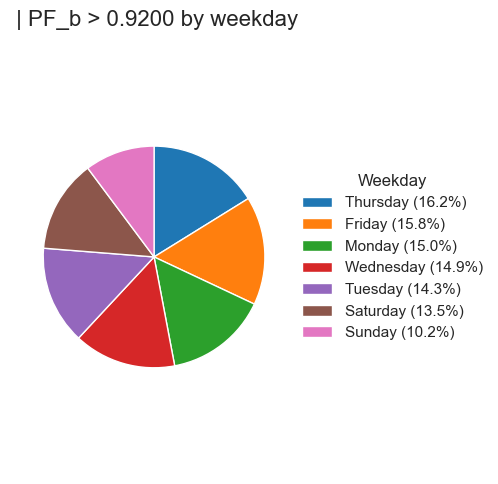

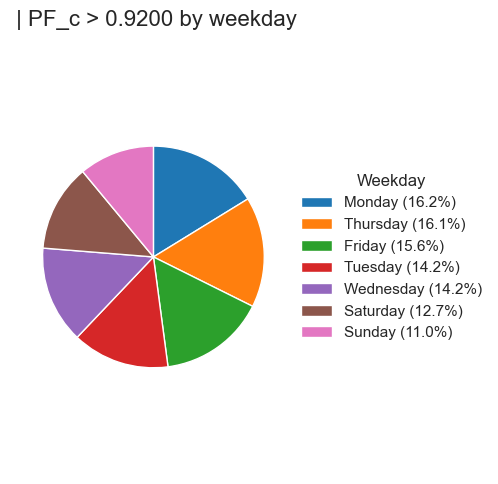

In [23]:
create_pie_chart_by_weekday_sns(data_PF, 'PF_a', 'flag_FP_a', pf_limit)
create_pie_chart_by_weekday_sns(data_PF, 'PF_b', 'flag_FP_b', pf_limit)
create_pie_chart_by_weekday_sns(data_PF, 'PF_c', 'flag_FP_c', pf_limit)